In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import numpy as onp
import time
from tqdm import tqdm
from led_array.bsccm_utils import *
from plot_utils import *
from led_array.bsccm_utils import *
from image_utils import *
from matplotlib.colors import LinearSegmentedColormap
from jax import jit
import jax.numpy as np


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


## Estimate stationary gaussian processes and draw samples from them

Loading images: 3it [03:44, 74.90s/it]
Computing covariance matrices and sampling: 0it [00:00, ?it/s]
100%|███████████████████████████████| 60000/60000 [00:00<00:00, 912013.39it/s]


computing cov mat



100%|█████████████████████████████████████████| 99/99 [00:05<00:00, 17.48it/s]


making positive definite
Matrix not positive definite. Adding 28.452457427978516 to eigenvalues



precomputing masks and variances: 100%|███████| 80/80 [04:36<00:00,  3.46s/it]


generating samples



generating sample: 100%|██████████████████████| 80/80 [00:50<00:00,  1.58it/s]

generating sample: 100%|██████████████████████| 80/80 [00:43<00:00,  1.85it/s]

generating sample: 100%|██████████████████████| 80/80 [00:42<00:00,  1.88it/s]

generating sample: 100%|██████████████████████| 80/80 [00:44<00:00,  1.79it/s]

generating sample: 100%|██████████████████████| 80/80 [00:42<00:00,  1.89it/s]
Computing covariance matrices and sampling: 1it [09:03, 543.66s/it]
100%|███████████████████████████████| 60000/60000 [00:00<00:00, 985820.32it/s]


computing cov mat



100%|█████████████████████████████████████████| 99/99 [00:02<00:00, 36.60it/s]


making positive definite



precomputing masks and variances: 100%|███████| 80/80 [02:57<00:00,  2.22s/it]


generating samples



generating sample: 100%|██████████████████████| 80/80 [00:42<00:00,  1.88it/s]

generating sample: 100%|██████████████████████| 80/80 [00:42<00:00,  1.90it/s]

generating sample: 100%|██████████████████████| 80/80 [00:42<00:00,  1.89it/s]

generating sample: 100%|██████████████████████| 80/80 [00:42<00:00,  1.88it/s]

generating sample: 100%|██████████████████████| 80/80 [00:42<00:00,  1.88it/s]
Computing covariance matrices and sampling: 2it [15:44, 459.51s/it]
100%|███████████████████████████████| 60000/60000 [00:00<00:00, 928436.34it/s]


computing cov mat



100%|█████████████████████████████████████████| 99/99 [00:02<00:00, 36.66it/s]


making positive definite
Matrix not positive definite. Adding 72.1089859008789 to eigenvalues



precomputing masks and variances: 100%|███████| 80/80 [02:57<00:00,  2.22s/it]


generating samples



generating sample: 100%|██████████████████████| 80/80 [00:42<00:00,  1.88it/s]

generating sample: 100%|██████████████████████| 80/80 [00:43<00:00,  1.84it/s]

generating sample: 100%|██████████████████████| 80/80 [00:43<00:00,  1.85it/s]

generating sample: 100%|██████████████████████| 80/80 [00:44<00:00,  1.81it/s]

generating sample: 100%|██████████████████████| 80/80 [00:43<00:00,  1.83it/s]
Computing covariance matrices and sampling: 3it [22:28, 449.49s/it]


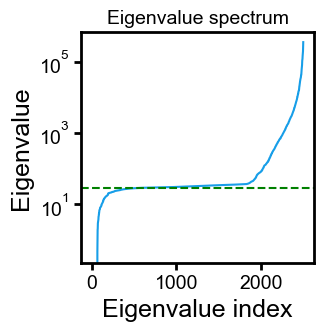

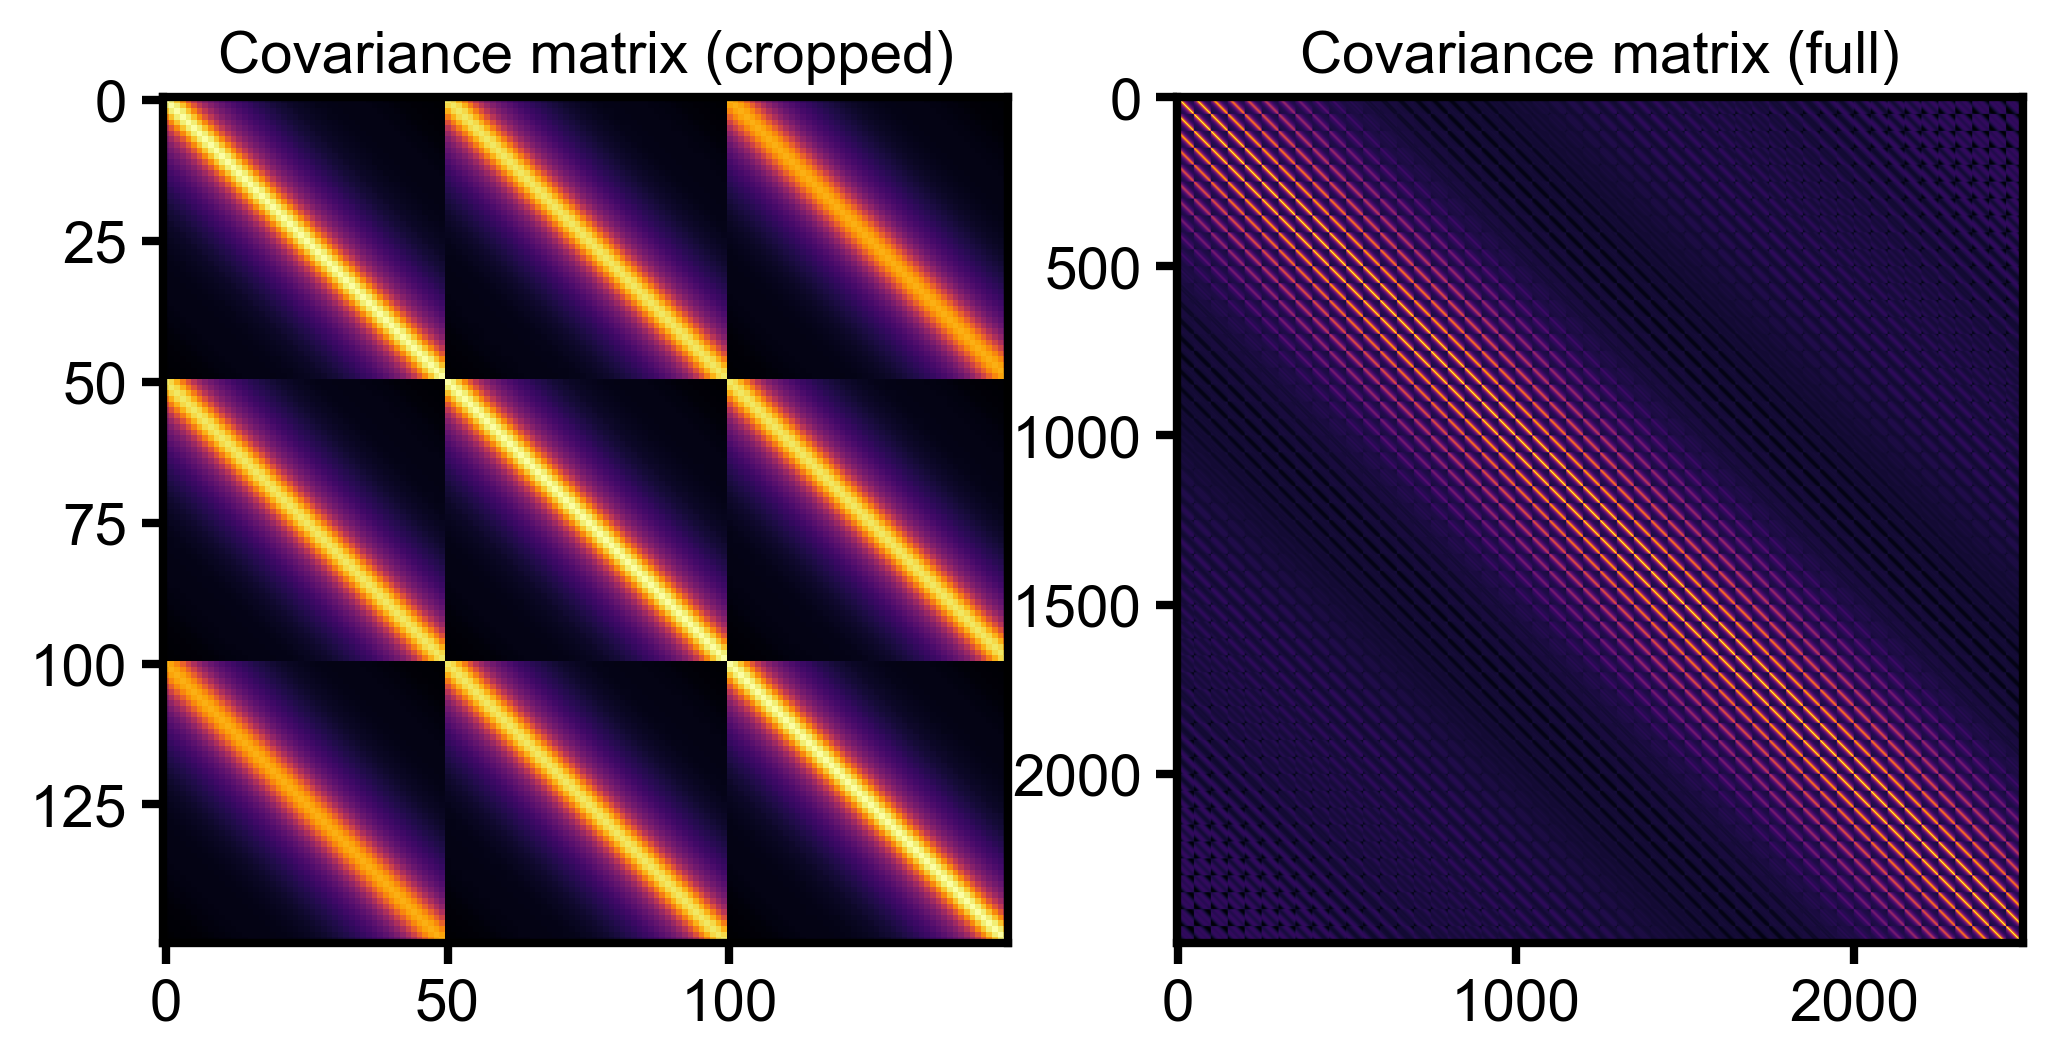

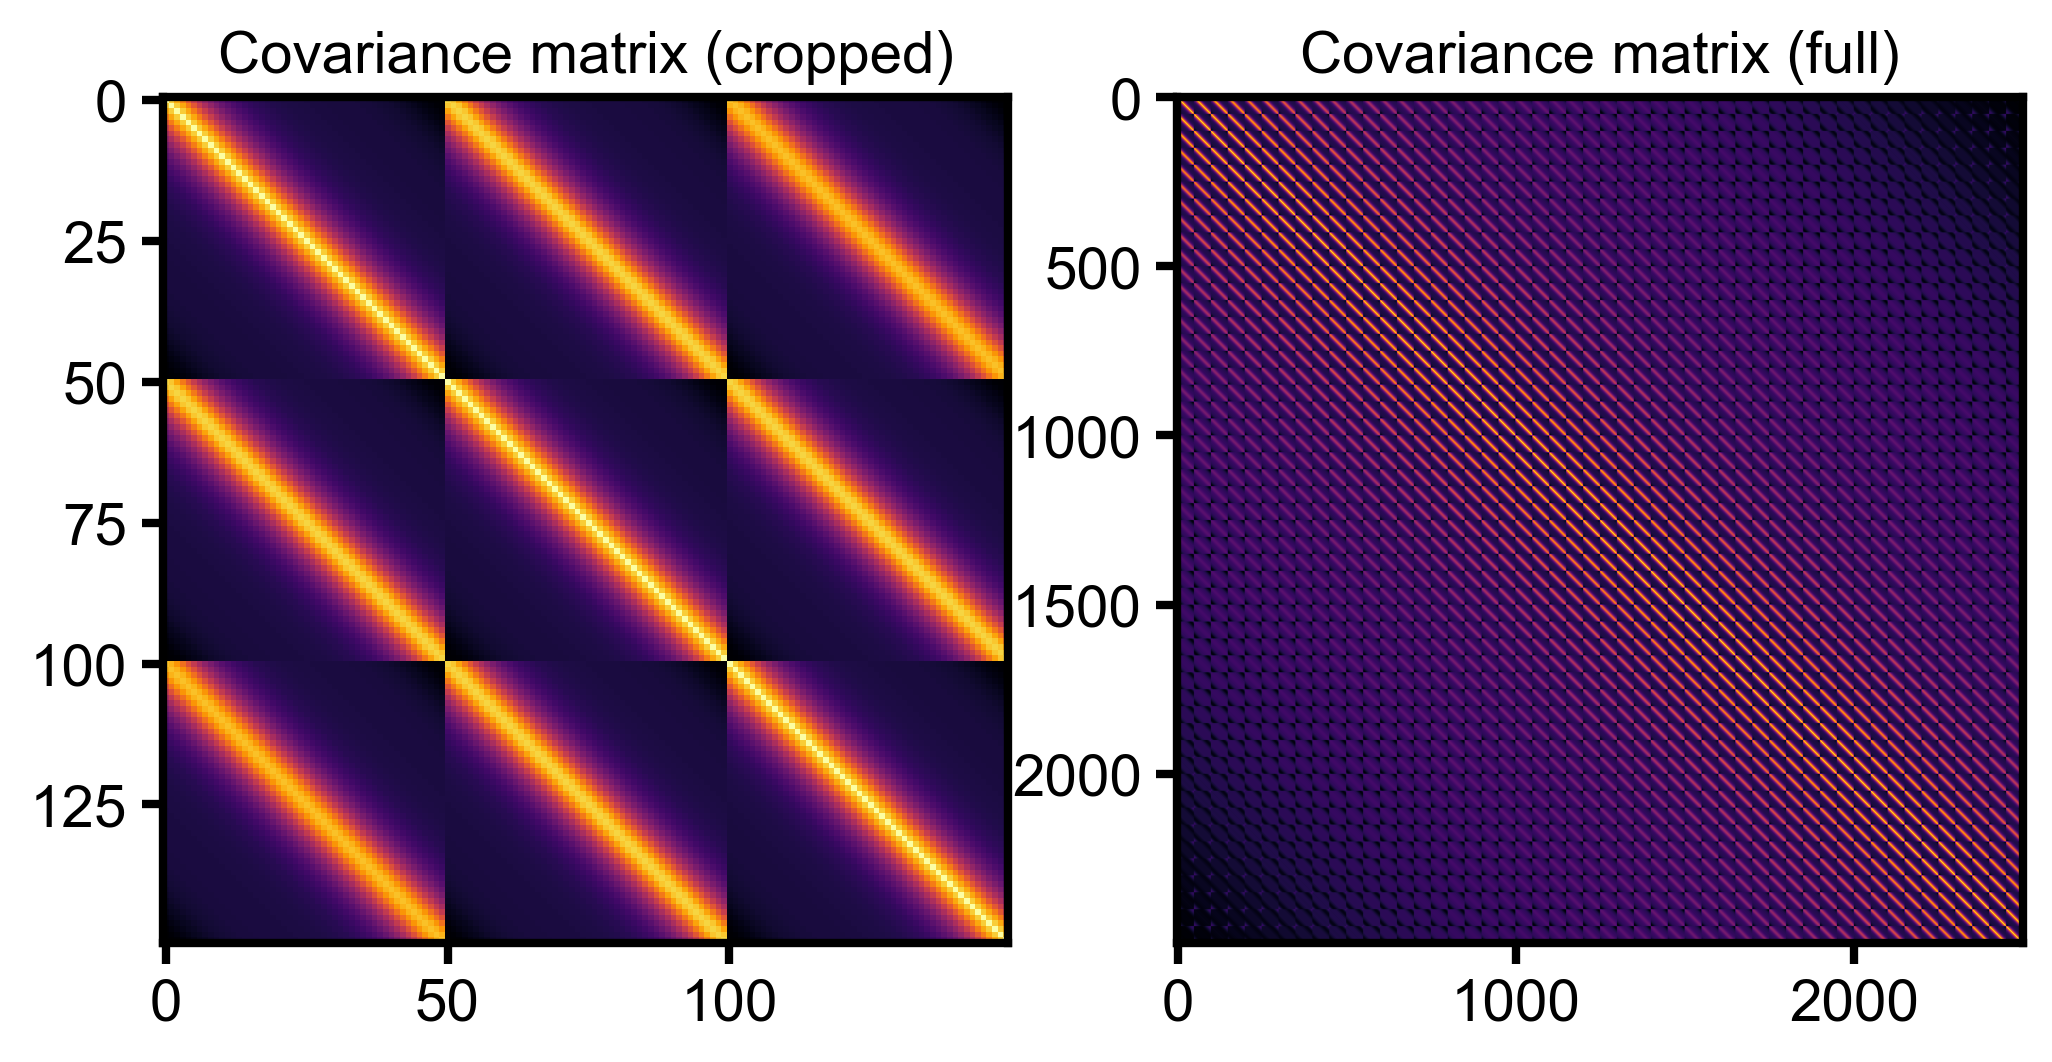

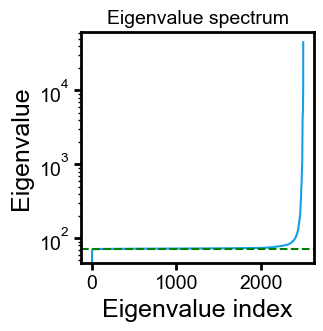

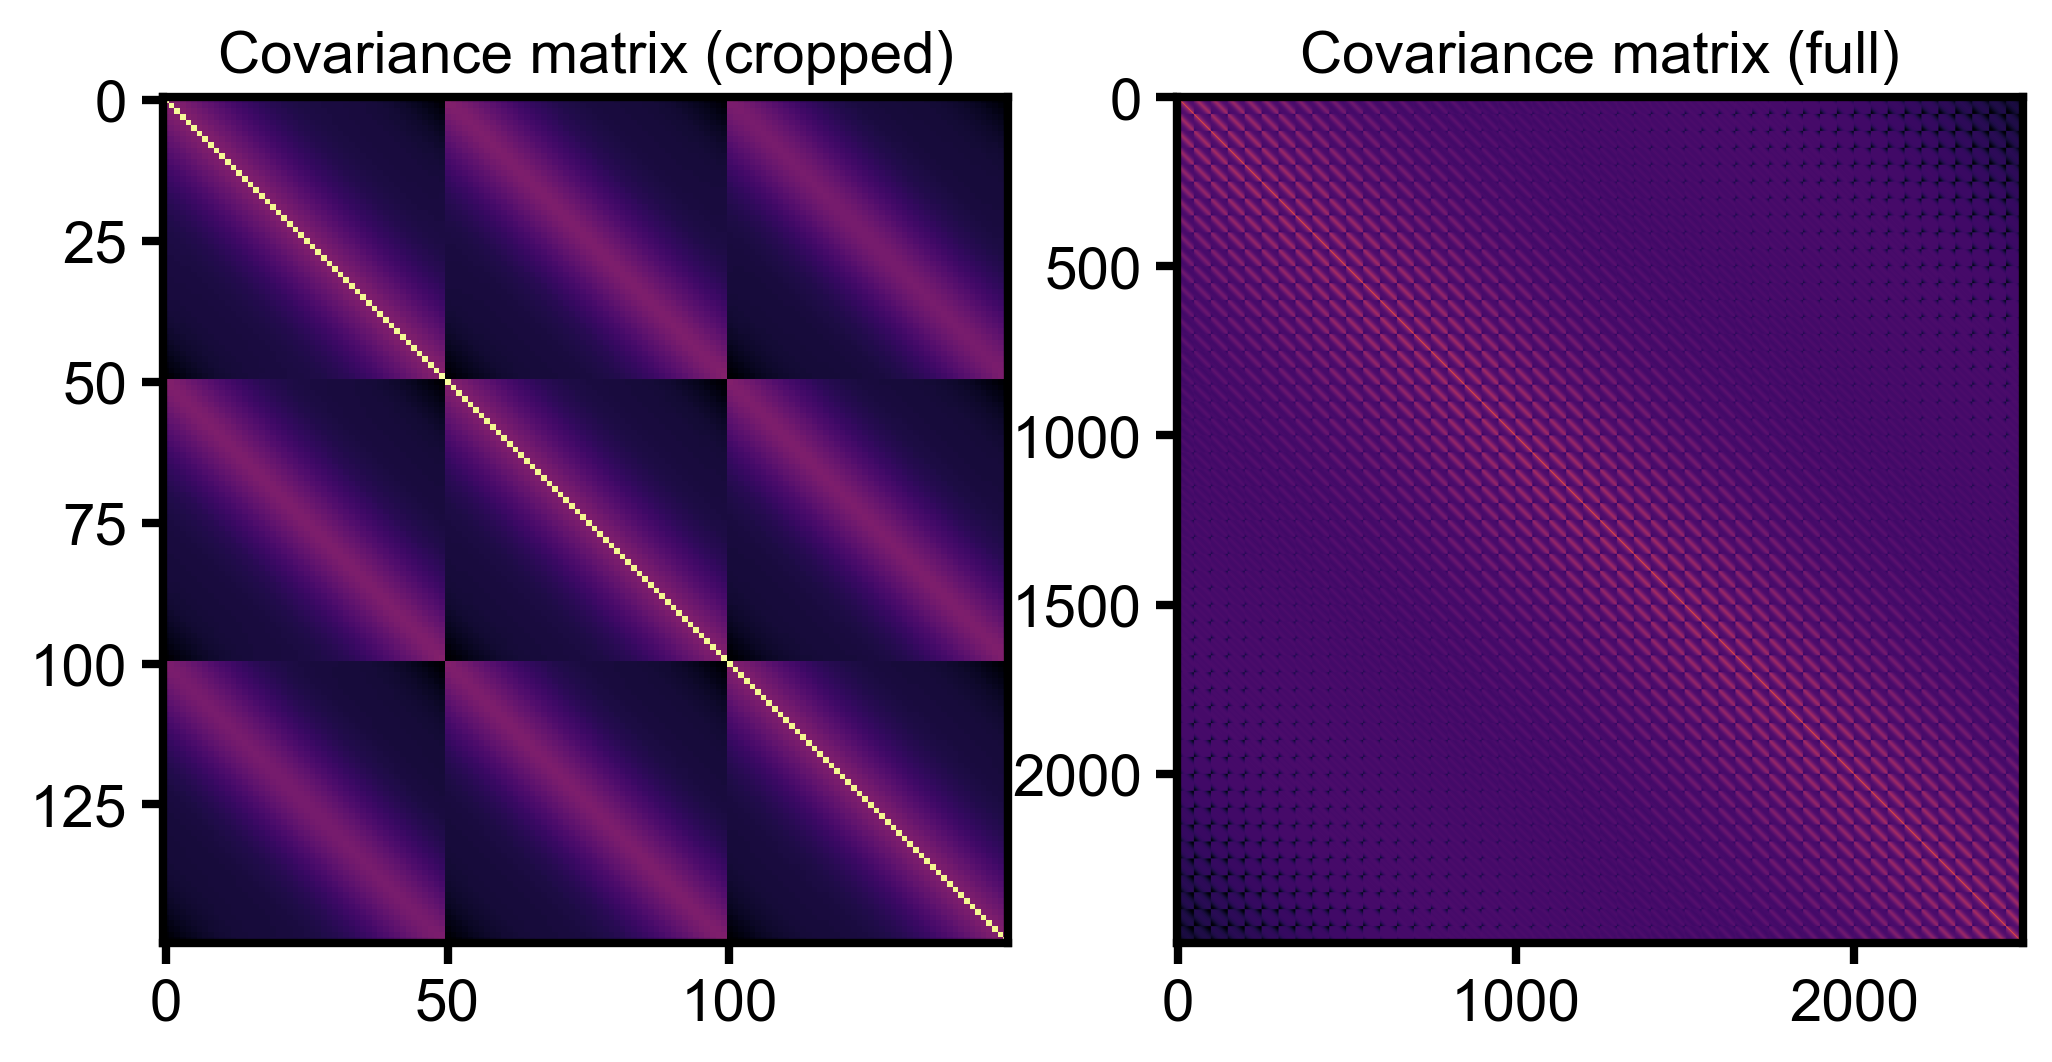

In [5]:
# images used to generate the covariance matrix
num_images = 25000
num_patches = 60000
edge_crop = 24

patch_size = 50 # the size of patches to estimate the covariance matrix from
sample_size = 128 - 2 * edge_crop # the size of the samples to generate
num_samples = 5

# num_images = 250
# num_patches = 600
# patch_size = 5
# sample_size = 5

photons_per_pixel = 150

channels = ['LED119', 'DPC_Right', 'Brightfield']
# channels = ['LED119', 'DPC_Right']
# channels = ['LED119']


image_samples = {}
noisy_patches_by_channel = {}
images_by_channel = {}
noisy_images_by_channel = {}
for channel_index, channel in tqdm(enumerate(channels), desc='Loading images'):
    images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
    images_by_channel[channel] = images[:num_samples * 10]
    noisy_images_by_channel[channel] = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))

for channel_index, channel in tqdm(enumerate(channels), desc='Computing covariance matrices and sampling'):
    noisy_patches = extract_patches(noisy_images_by_channel[channel], patch_size=patch_size, num_patches=num_patches, seed=1234)
    noisy_patches_by_channel[channel] = noisy_patches[: num_samples * 10] # for display

    print('computing cov mat')
    cov_mat = compute_stationary_cov_mat(noisy_patches)
    print('making positive definite')
    cov_mat = make_positive_definite(cov_mat, cutoff_percentile=20, show_plot=True)
    # cov_mat = compute_cov_mat(patches) # non-stationary version

    # plot the cov mat
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
    ax[0].imshow(cov_mat[:150, :150], cmap='inferno')
    ax[1].imshow(cov_mat, cmap='inferno')
    ax[0].set(title='Covariance matrix (cropped)')
    ax[1].set(title='Covariance matrix (full)')
    fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + f'stationary_cov_mat_{channel}' + '.pdf', transparent=True)

    samples = generate_stationary_gaussian_process_samples(cov_mat, sample_size, num_samples, 
    prefer_iterative_sampling=False, mean=np.mean(noisy_patches), seed=channel_index * 1000)
    image_samples[channel] = samples
    

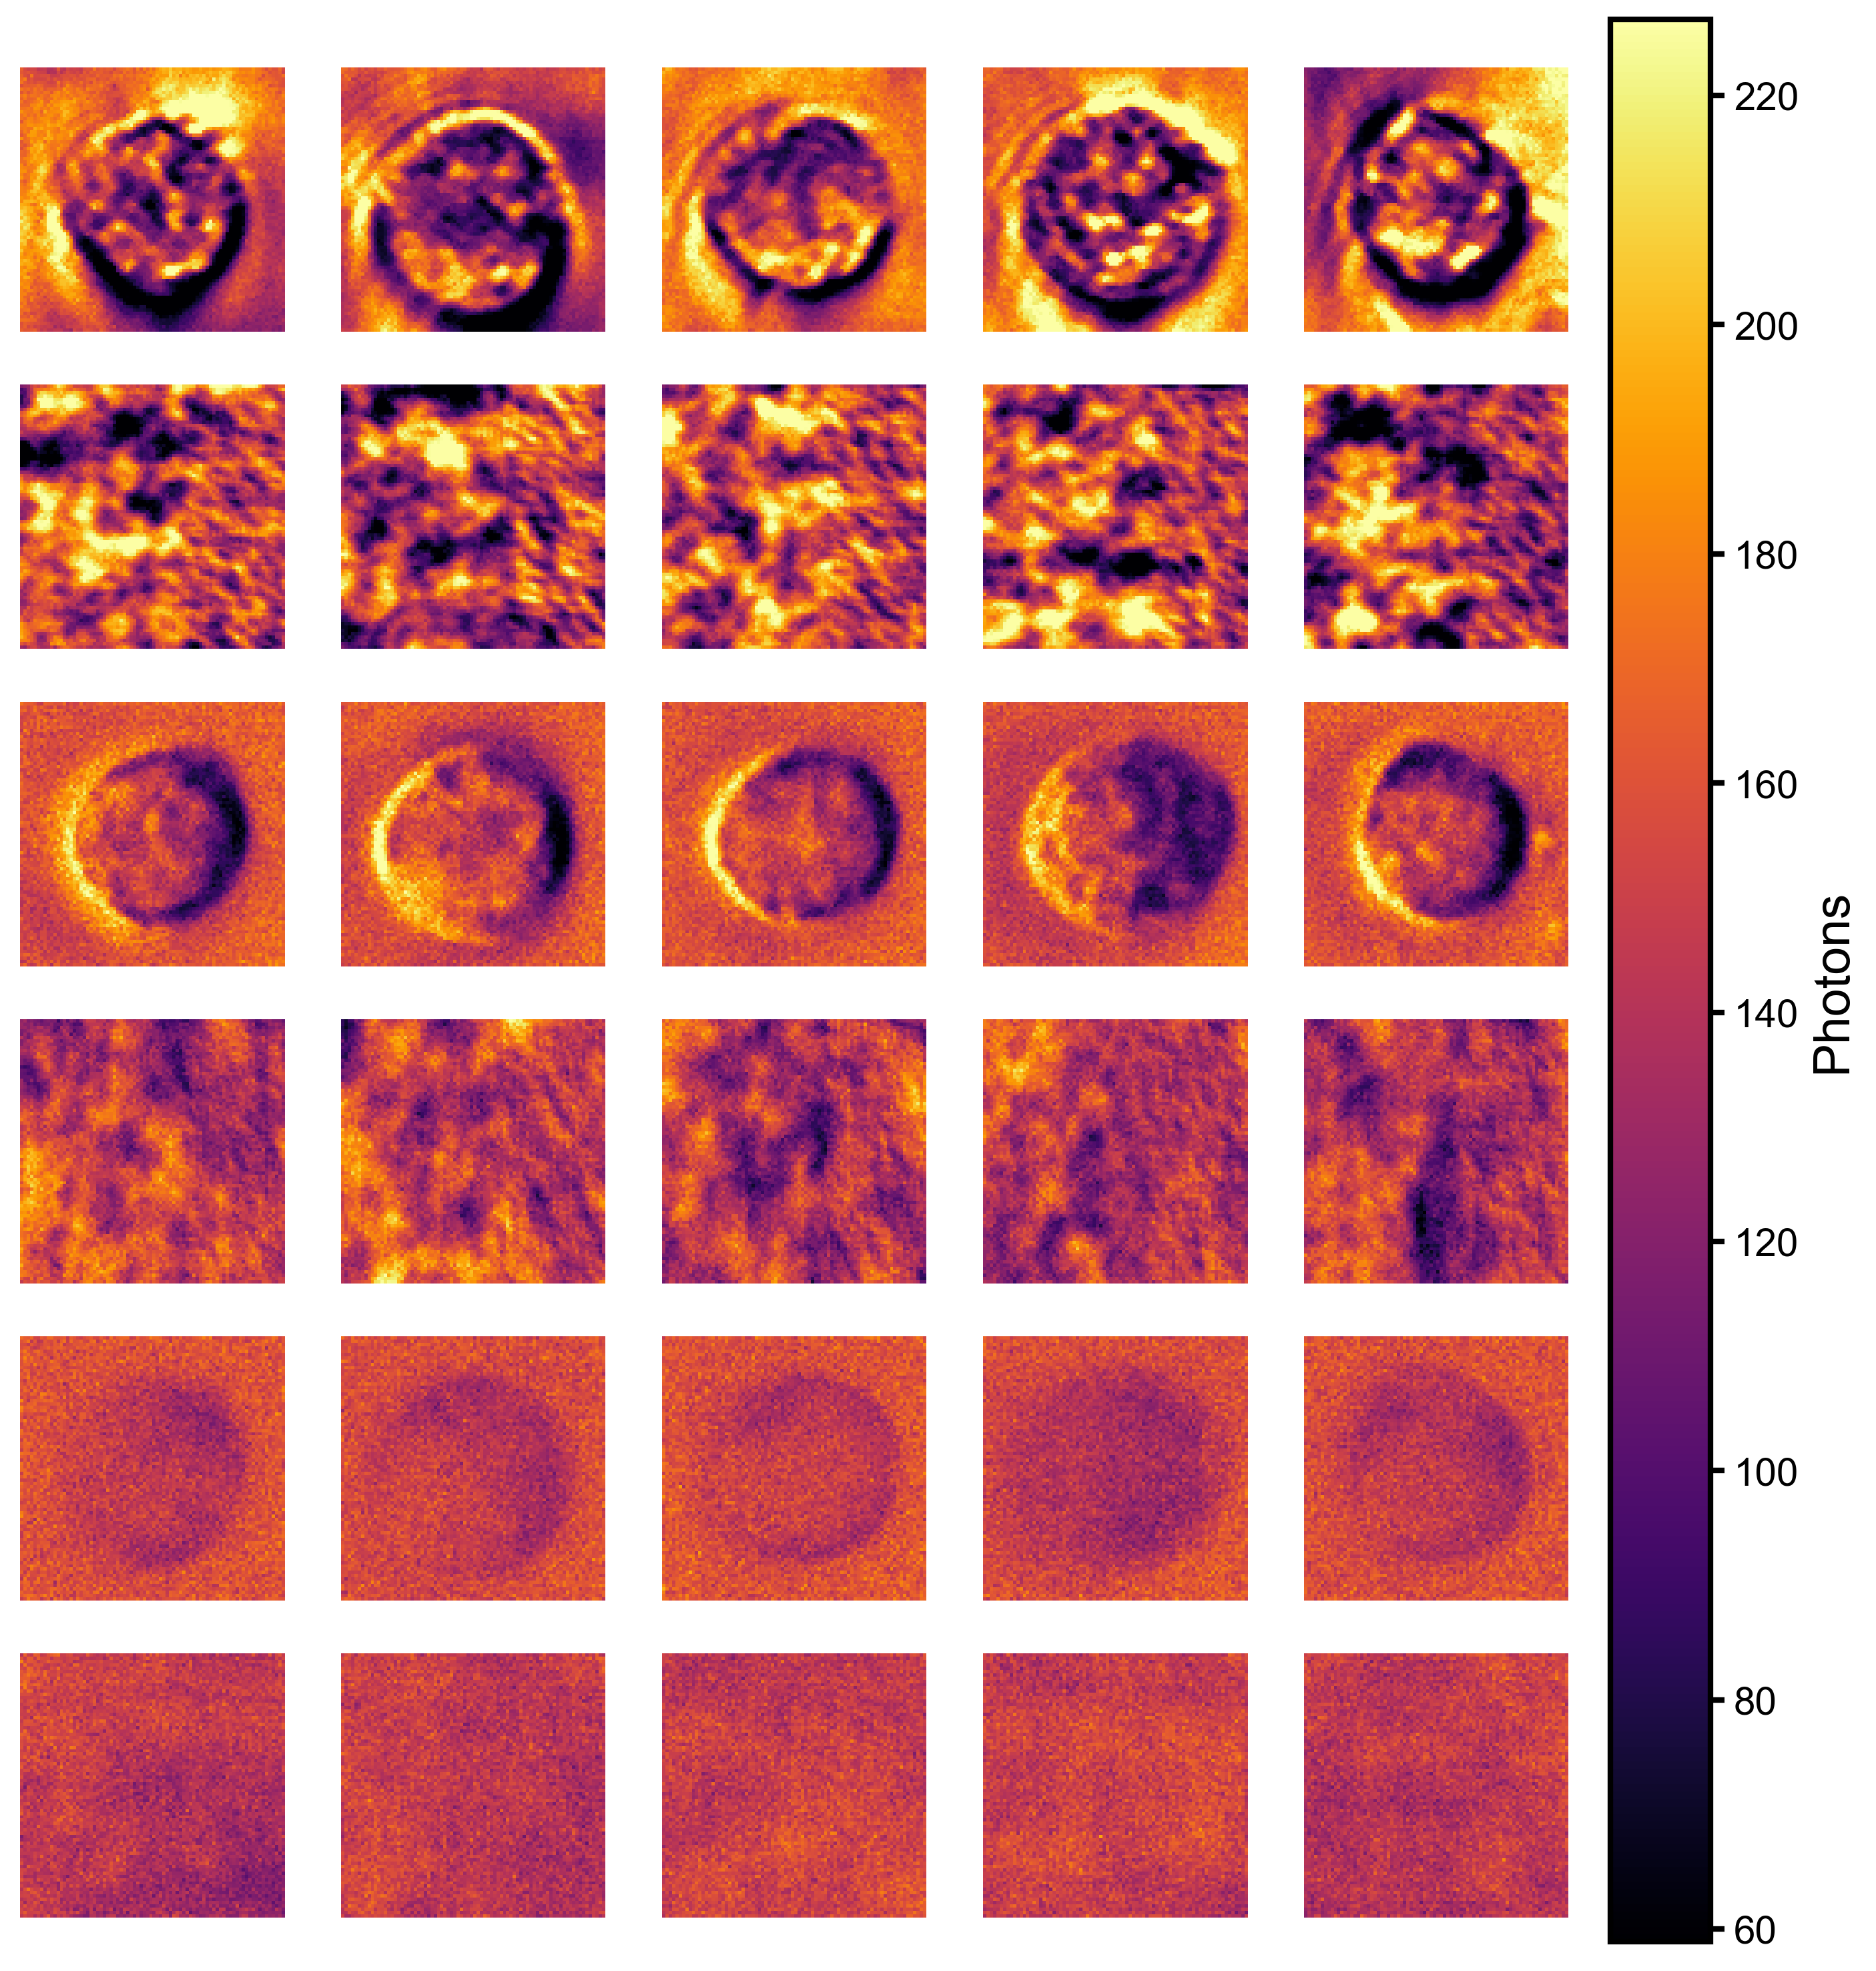

In [6]:
# TODO: put all images in same contrast
# take the min and max over all channels
# concatenate all pixels for all channels from both images and samples
# then take the min and max over all pixels
all_pix = onp.concatenate([onp.array(noisy_patches_by_channel[channel]) for channel in channels])
# vmin = np.percentile(all_pix, 1)
# vmax = np.percentile(all_pix, 99)
vmin, vmax = (60, 230)

fig, image_sample_ax = plt.subplots(len(channels) * 2, num_samples, 
                                figsize=(num_samples * 2, len(channels) * 2 * 2), dpi=300)
for channel_index, channel in enumerate(channels):
    # images = patches_by_channel[channel]
    images = images_by_channel[channel][[1, 3, 19, 5, 11]]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    samples = image_samples[channel]
    for i in range(num_samples):
        im = image_sample_ax[channel_index * 2, i].imshow(noisy_images[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2, i].axis('off')
        image_sample_ax[channel_index * 2 + 1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2 + 1, i].axis('off')
        

    image_sample_ax[channel_index*2, 0].set_ylabel(channel + '\n(images)')
    image_sample_ax[channel_index*2 + 1, 0].set_ylabel(channel + '\n(samples)')

# show one big colorbar on the right side spanning all rows
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label='Photons')

fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'intro_images_and_samples' + '.pdf', transparent=True)

## 